# Flower Classification with Pre-trained ResNet50 

This notebook classifies images of flowers. A state-of-the-art pre-trained `ResNet50` is used to train on the Flowers dataset.

In this notebook, two ways to customize a pretrained model will be performed:

1. Feature Extraction: Representation learned by a previous network will be used to extract meaningful features from new samples. This will be done by simply adding a new classifier, which will be trained from scratch, on top of the pretrained model.

2. Fine-Tuning: Unfreezing a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows for fine tuning the higher-order feature representations in the base model in order to make them more relevant for the specific task.

This project will follow the general machine learning workflow:
1. Examine and understand the data
2. Build an input pipeline, in this case using Keras ImageDataGenerator
3. Compose the model
  - Load in the pretrained base model (and pretrained weights)
  - Stack the classification layers on top
4. Train the model
5. Evaluate the model

## Setup

In [2]:
!pip install -U -q scipy

In [3]:
import os
import shutil
import pathlib
import numpy as np
import pandas as pd
from PIL import Image
from scipy import io
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import load_img, img_to_array

### Utility Functions

In [9]:
def get_map_id(img_file):
  """
  Function to get the id of each image 

  Arg:
  img_file (string) -- Image to get the id

  Returns:
  img_id (int) -- Id of image
  """

  splitted_str = img_file.split(".")
  img_id = int(splitted_str[0][-4:])
  
  return img_id

In [11]:
def map_data(idx, mapped_data, data_ids, image_dir=image_dir):
  """
  Function to map an image and label with their id

  Args:
  idx (int) -- Index of an image and label pair
  mapped_data (tuple) -- An image and label pair
  data_ids (list) -- A list of ids for the images and labels
  image_dir (string) - Directory of the images

  Returns:
  img_path (string) -- Path to the image
  img (string) -- The image
  label (string) -- Label of the image
  """

  map_id = get_map_id(mapped_data[idx][0])
  img_path = os.path.join(image_dir, mapped_data[idx][0])
  if map_id in data_ids:    
    img = mapped_data[idx][0]
    label = mapped_data[idx][1]

    return img_path, img, label 


In [12]:
def get_image_data(data, data_ids):
  """
  Function to map ids to images and store in DataFrame

  Args:
  mapped_data_list (list) -- A list of sorted images and their labels in tuples i.e. (image, label) 
  data_ids (list) -- A list of ids of the images to be mapped to
  image_dir (string) -- The image directory

  Returns:
  image_data_df (DataFrame) -- Returns a DataFrame of the mapped data
  """

  image_data = {
        'image_path': [],
        'image': [],
        'label': []
    }

  for idx in range(len(data)):
    mp_data = map_data(idx, data, data_ids)
    if mp_data:
      img_path, img, label = mp_data
      image_data['image_path'].append(img_path)
      image_data['image'].append(img)
      image_data['label'].append(label)

  image_data_df = pd.DataFrame(image_data)

  return image_data_df

In [17]:
def create_sub_dir(df, root_dir, inter_dir):
  """
  Function to create sub directory for data (e.g. train directory)

  Arg:
  df (DataFrame) -- DataFrame of the data 
  """
  
  orig_dir = pathlib.Path(root_dir)
  inter_dir_list = df.label.unique()
  for d in inter_dir_list:
    dir  = orig_dir / inter_dir / str(d)
    os.makedirs(dir)


In [18]:
def trn_data(df, dst):
  """
  Function to copy data from one directory to another

  Args:
  df (DataFrame) -- DataFrame of the data
  dst (string) -- Destination directory data is being copied to 
  """

  for i in range(len(df)):
    image_path = df.image_path[i]
    image = df.image[i]
    label = df.label[i]
    dst_dir = pathlib.Path(dst, str(label), image)

    shutil.copy(image_path, dst_dir)

## Data Preprocessing

### Data Preparation

In [4]:
%%bash

tar -xf 102flowers.tgz

In [5]:
img_labels = io.loadmat('imagelabels.mat')
labels = img_labels['labels'].reshape(-1)
print(f"Shape of labels", labels.shape)

Shape of labels (8189,)


In [6]:
setid = io.loadmat('setid.mat')
trn_ids = setid['trnid'].reshape(-1)
val_ids = setid['valid'].reshape(-1)
tst_ids = setid['tstid'].reshape(-1)

In [7]:
print("Train data ids:", trn_ids)
print("Validation data ids:", val_ids)
print("Test data ids:", tst_ids)

Train data ids: [6765 6755 6768 ... 8026 8036 8041]
Validation data ids: [6773 6767 6739 ... 8028 8008 8030]
Test data ids: [6734 6735 6737 ... 8044 8045 8047]


In [8]:
image_dir = 'jpg/'
img_list = os.listdir(image_dir)
sorted_img_list = sorted(img_list)
data = list(zip(sorted_img_list, labels))

In [13]:
train_data = get_image_data(data, trn_ids)
val_data = get_image_data(data, val_ids)
test_data = get_image_data(data, tst_ids)

In [14]:
train_data.head()

,image_path,image,label
0,jpg/image_00028.jpg,image_00028.jpg,77
1,jpg/image_00036.jpg,image_00036.jpg,77
2,jpg/image_00079.jpg,image_00079.jpg,77
3,jpg/image_00116.jpg,image_00116.jpg,77
4,jpg/image_00118.jpg,image_00118.jpg,77


In [15]:
val_data.head()

,image_path,image,label
0,jpg/image_00017.jpg,image_00017.jpg,77
1,jpg/image_00023.jpg,image_00023.jpg,77
2,jpg/image_00038.jpg,image_00038.jpg,77
3,jpg/image_00055.jpg,image_00055.jpg,77
4,jpg/image_00082.jpg,image_00082.jpg,77


In [16]:
test_data.head()

,image_path,image,label
0,jpg/image_00001.jpg,image_00001.jpg,77
1,jpg/image_00002.jpg,image_00002.jpg,77
2,jpg/image_00003.jpg,image_00003.jpg,77
3,jpg/image_00004.jpg,image_00004.jpg,77
4,jpg/image_00005.jpg,image_00005.jpg,77


In [19]:
# Create root dir
!mkdir flower_data

In [20]:
root_dir = pathlib.Path("flower_data")

In [21]:
train_inter_dir = "train"
create_sub_dir(train_data, root_dir, train_inter_dir)

In [22]:
train_dst = root_dir / train_inter_dir
trn_data(train_data, train_dst)

In [23]:
val_inter_dir = "val"
create_sub_dir(val_data, root_dir, val_inter_dir)

In [24]:
val_dst = root_dir / val_inter_dir
trn_data(val_data, val_dst)

In [29]:
test_inter_dir = "test"
create_sub_dir(test_data, root_dir, test_inter_dir)

In [30]:
test_dst = root_dir / test_inter_dir
trn_data(test_data, test_dst)

In [31]:
from tensorflow.keras.utils import image_dataset_from_directory

BATCH_SIZE = 32
IMG_SIZE = (180, 180)

train_dataset = image_dataset_from_directory(
    root_dir / train_inter_dir,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=7,
    batch_size=BATCH_SIZE)

val_dataset = image_dataset_from_directory(
    root_dir / val_inter_dir,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=7,
    batch_size=BATCH_SIZE)

test_dataset = image_dataset_from_directory(
    root_dir / test_inter_dir,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=7,
    batch_size=BATCH_SIZE)

Found 1020 files belonging to 102 classes.
Found 1020 files belonging to 102 classes.
Found 6149 files belonging to 102 classes.


In [26]:
class_names = train_dataset.class_names

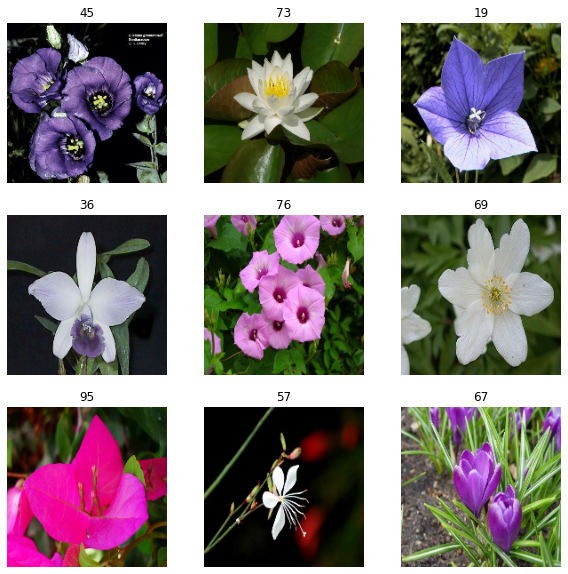

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Preprocess and Augment Training Data

Using `prefetch()` to prevent memory bottleneck that can occur when reading from disk. This sets aside some data and keeps it ready for training when it's needed, by creating a source dataset from the input data, applying transformation to preprocess it, then iterating over the dataset one element at a time. Because the iteration is streaming, the data doesn't need to fit into memory.

Using `tf.data.experimental.AUTOTUNE` to automatically choose the number of elements (parameters) to prefetch. AUTOTUNE prompts `tf.data` to tune the value dynamically at runtime, by tracking the time spent in each operation and feeding those times into an optimization algorithm. The optimization algorithm tries to find the best allocation of its CPU budget across all tunable operations.

In [32]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

- This is to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. 
- This helps to reduce *overfitting* by exposing the model to different aspects of the training data.

In [33]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)
])

Repeatly apply *data augmentation* layers to the same image and see the result

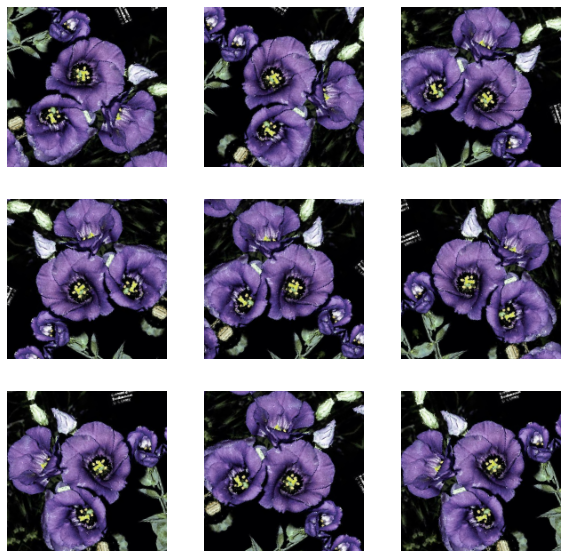

In [35]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

Use the preprocessing method of the `resnet50` model to rescale the data. This makes sure the data is rescaled in accordance with the necessary data required for `resnet50` model.


In [36]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

## Create the base model from the pre-trained convnets

Create the base model for **ResNet50** model. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. The base of knowledge will help to classify the flowers in this project's dataset.

This project will depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

- Instantiate a **ResNet50** model pre-loaded with weights trained on ImageNet.
- Specify the `include_top=False` argument, the network loaded doesn't include the classification layers at the top, which is ideal for feature extraction.

In [37]:
# Create the base mode from the pre-trained model ResNet50
IMG_SHAPE = IMG_SIZE + (3,)
base_model = keras.applications.resnet50.ResNet50(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

94765736/94765736 [==============================] - 3s 0us/step


The feature extractor converts `180x180x3` image into a `6x6x2048` block of features.

Check out an example with a batch of images:

In [40]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 2048)


## Feature extraction

- Freeze the convolutional base created from the previous step and to use as a feature extractor.
- Add a classfier on top of it and train the top-level classifier.

#### Freeze the convolutional base

Freezing the convolutional base before compiling and training the model is an important step in *transfer learning*. This prevents the weights in a given layer from being updated during training. Freezing the convolutional base is done by setting `layer.trainable = False`. 

ResNet50 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [41]:
base_model.trainable = False

Check out the base model architecture

In [42]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 186, 186, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 90, 90, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 90, 90, 64)   256         ['conv1_conv[0][0]']      

#### Add a classification head

To generate predictions from the block of features, average over the spatial 6x6 spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to a single 2048-element vector per image.

In [43]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. 

In [45]:
prediction_layer = tf.keras.layers.Dense(102, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 102)


Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers.
- Use `training=False` because thet model contains a `BatchNormalization` layer. This is to make the `BatchNormalization` layer run in inference mode, and will not update its mean and variance statistics. This is to prevent the updates applied to the non-trainable weights from destroying what the model has learned.

In [48]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

#### Set Callbacks

In [51]:
!mkdir saved_models

In [52]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="saved_models/resnet50_classifier.keras",
        save_best_only=True,
        monitor="val_loss"),

    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20)
]

#### Compile the model

Compile the model before training it.

In [50]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [53]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 180, 180, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 180, 180, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0   

The 23.7 million parameters in MobileNet are frozen, but there are 208 thousand trainable parameters in the Dense layer. These are divided between two `tf.Variable` objects, the weights and biases.

In [54]:
len(model.trainable_variables)

2

#### Train the model

In [59]:
initial_epochs = 100

history = model.fit(
    train_dataset, 
    epochs=initial_epochs,
    validation_data=val_dataset,
    callbacks=callbacks)

Epoch 1/100
32/32 [==============================] - 10s 287ms/step - loss: 0.1974 - accuracy: 0.9902 - val_loss: 0.7149 - val_accuracy: 0.8382
Epoch 2/100
32/32 [==============================] - 9s 283ms/step - loss: 0.2072 - accuracy: 0.9863 - val_loss: 0.7118 - val_accuracy: 0.8392
Epoch 3/100
32/32 [==============================] - 9s 285ms/step - loss: 0.1883 - accuracy: 0.9873 - val_loss: 0.7072 - val_accuracy: 0.8363
Epoch 4/100
32/32 [==============================] - 10s 293ms/step - loss: 0.1819 - accuracy: 0.9912 - val_loss: 0.7041 - val_accuracy: 0.8382
Epoch 5/100
32/32 [==============================] - 9s 268ms/step - loss: 0.1841 - accuracy: 0.9922 - val_loss: 0.7020 - val_accuracy: 0.8382
Epoch 6/100
32/32 [==============================] - 9s 261ms/step - loss: 0.1706 - accuracy: 0.9961 - val_loss: 0.7012 - val_accuracy: 0.8392
Epoch 7/100
32/32 [==============================] - 9s 283ms/step - loss: 0.1724 - accuracy: 0.9931 - val_loss: 0.7005 - val_accuracy: 0.84

#### Learning Curves

Check out the learning curves of the training and validation accuracy/loss when using ResNet50 base model as a fixed feature extractor.

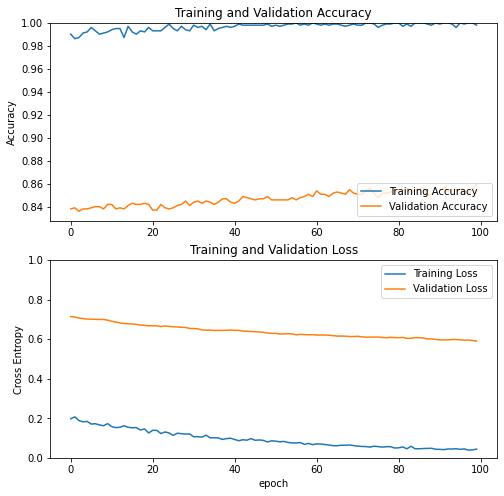

In [62]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Evaluate model on validation dataset

In [61]:
loss0, acc0 = model.evaluate(val_dataset)
print("\nAccuracy and Loss:\n")
print("Accuracy:", f"{round(acc0 * 100, 2)}%")
print("Loss:", f"{loss0}")

32/32 [==============================] - 4s 94ms/step - loss: 0.5899 - accuracy: 0.8598

Accuracy and Loss:

Accuracy: 85.98%
Loss: 0.5899360179901123


Load best saved model and evaluate again

In [68]:
saved_model = keras.models.load_model("saved_models/resnet50_classifier.keras")

In [69]:
saved_loss0, saved_acc0 = saved_model.evaluate(val_dataset)
print("\nSaved Accuracy and Loss:\n")
print("Saved Accuracy:", f"{round(saved_acc0 * 100, 2)}%")
print("Saved Loss:", f"{saved_loss0}")

32/32 [==============================] - 4s 81ms/step - loss: 0.5899 - accuracy: 0.8598

Saved Accuracy and Loss:

Saved Accuracy: 85.98%
Saved Loss: 0.5899360179901123


The classifier trained with pre-trained ResNet50 acheives an accuracy of 100% on the training data. However, the model is *overfitting* as the validation accuracy is 85.98% which is a 14.02% decrease from the training accuracy. 

## Fine Tuning

We saw that there was *overfitting* while training the data. Here we will attempt to improve the model by *fine tuning* the model arcitecture.

One way to improve performance is to train or *fine-tune* the weights of the top layers of the pre-trained model alongside the training of the classifier that was added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

#### Un-freeze the top layers of the model

Unfreeze the `base_model` and set the bottom layers to be untrainable. Then recompile the model (necessary for these changes to take effect), and resume training.

In [65]:
base_model.trainable = True

In [84]:
# Check out how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  175


#### Set Callbacks

In [85]:
fine_tuned_callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="saved_models/fine_tuned_resnet50_classifier.keras",
        save_best_only=True,
        monitor="val_loss"),

    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20)
]

Compile the model

Lower the learning rate at this stage because we are training a larger model and want to readapt the pretrained weights. Otherwise, the model could overfit very quickly.

In [86]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate * 0.1),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [87]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 180, 180, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 180, 180, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0   

In [88]:
len(model.trainable_variables)

44

#### Continue training the model

In [89]:
fine_tuned_epochs = 50
total_epochs =  initial_epochs + fine_tuned_epochs

fine_tuned_history = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_dataset,
                         callbacks=fine_tuned_callbacks)

Epoch 100/150


32/32 [==============================] - 21s 333ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.9425 - val_accuracy: 0.8206
Epoch 101/150
32/32 [==============================] - 10s 280ms/step - loss: 0.0031 - accuracy: 0.9990 - val_loss: 1.0360 - val_accuracy: 0.8157
Epoch 102/150
32/32 [==============================] - 10s 292ms/step - loss: 0.0040 - accuracy: 0.9990 - val_loss: 0.9526 - val_accuracy: 0.8186
Epoch 103/150
32/32 [==============================] - 10s 292ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.9712 - val_accuracy: 0.8235
Epoch 104/150
32/32 [==============================] - 12s 358ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.9708 - val_accuracy: 0.8343
Epoch 105/150
32/32 [==============================] - 12s 358ms/step - loss: 0.0027 - accuracy: 0.9990 - val_loss: 0.9429 - val_accuracy: 0.8363
Epoch 106/150
32/32 [==============================] - 12s 359ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.9783 - val_accuracy:

In [91]:
acc += fine_tuned_history.history['accuracy']
val_acc += fine_tuned_history.history['val_accuracy']

loss += fine_tuned_history.history['loss']
val_loss += fine_tuned_history.history['val_loss']

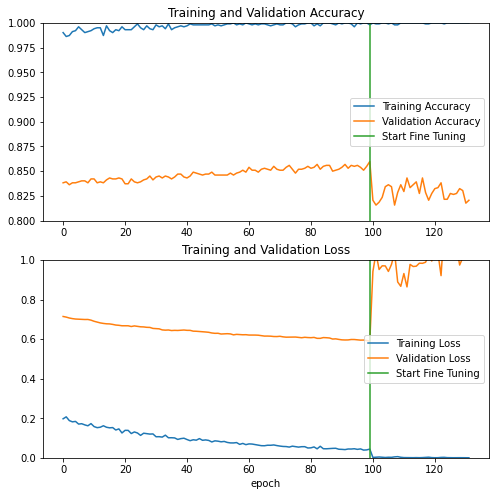

In [94]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='center right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='center right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

As seen in the results, it seems that the fine tuned model performs worse than the original model. The validation accuracy seems to go further away from the training accuracy. This means the fine tuned model is *overfitting* the more. Due to this result, the original model will be used as this model's classifier. 

#### Evaluation and prediction

Verify the performance of the model on new data using test set

In [95]:
test_loss, test_accuracy = saved_model.evaluate(test_dataset)
print('Test accuracy :', test_accuracy)

193/193 [==============================] - 19s 93ms/step - loss: 0.7342 - accuracy: 0.8185
Test accuracy : 0.8185070753097534


In [108]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = saved_model.predict_on_batch(image_batch)

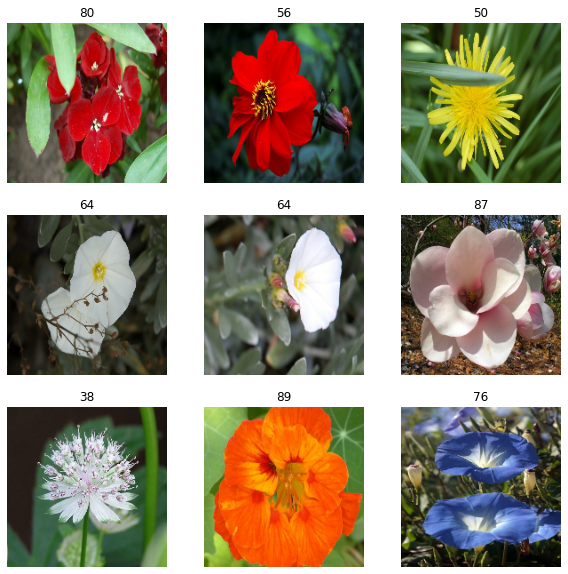

In [123]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[np.argmax(predictions[i])])
  plt.axis("off")

## Conclusion

In this project, we were able to acheive 100% accuracy both on the *original* model and *fine tuned* model. However, we saw that there was more overfitting after fine tuning the model, so we used the original model as the classifier. This could be because of the small sample used for training. It is best to have a larger sample for training to get a more efficient model. 

For future work, we can experiment with other Deep Learning pretrained model architectures such as `EfficientNet`, and `MobileNet V2` and compare their performances with ResNet50.